In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute
from qiskit.quantum_info import random_statevector
import numpy as np
from scipy.optimize import fmin_cobyla
import matplotlib.pyplot as plt

In [2]:
'''
    initial quantum register and quantum circuit for experiment
'''
qr = QuantumRegister(4)
cr = ClassicalRegister(4)

In [3]:
'''
    construct prototype of Even block with rotation Z and control-Z
'''
def Even(params=[0,0,0,0]):
    qc = QuantumCircuit(qr)
    qc.rz(params[0],0)
    qc.rz(params[1],1)
    qc.rz(params[2],2)
    qc.rz(params[3],3)
    qc.cz(0,1)
    qc.cz(0,2)
    qc.cz(0,3)
    qc.cz(1,2)
    qc.cz(1,3)
    qc.cz(2,3)
    return qc

In [4]:
Even().draw()

┌───────┐                  
q0_0: ┤ RZ(0) ├─■──■──■──────────
      ├───────┤ │  │  │          
q0_1: ┤ RZ(0) ├─■──┼──┼──■──■────
      ├───────┤    │  │  │  │    
q0_2: ┤ RZ(0) ├────■──┼──■──┼──■─
      ├───────┤       │     │  │ 
q0_3: ┤ RZ(0) ├───────■─────■──■─
      └───────┘

In [5]:
'''
    construct prototype of Even block with rotation X
'''
def Odd(params=[0,0,0,0]):
    qc = QuantumCircuit(qr)
    qc.rx(params[0],0)
    qc.rx(params[1],1)
    qc.rx(params[2],2)
    qc.rx(params[3],3)
    return qc

In [6]:
Odd().draw()

┌───────┐
q0_0: ┤ RX(0) ├
      ├───────┤
q0_1: ┤ RX(0) ├
      ├───────┤
q0_2: ┤ RX(0) ├
      ├───────┤
q0_3: ┤ RX(0) ├
      └───────┘

In [7]:
'''
    Merge Odd circuit with Even circuit
'''
def LayerBlock(params):
    qc = QuantumCircuit(qr)
    qc+=Odd(params[0:4])
    qc.barrier()
    qc+=Even(params[4:8])
    qc.barrier()
    return qc

In [8]:
LayerBlock([0., 0., 0., 0., 0., 0., 0., 0.]).draw()

┌───────┐ ░ ┌───────┐                   ░ 
q0_0: ┤ RX(0) ├─░─┤ RZ(0) ├─■──■──■───────────░─
      ├───────┤ ░ ├───────┤ │  │  │           ░ 
q0_1: ┤ RX(0) ├─░─┤ RZ(0) ├─■──┼──┼──■──■─────░─
      ├───────┤ ░ ├───────┤    │  │  │  │     ░ 
q0_2: ┤ RX(0) ├─░─┤ RZ(0) ├────■──┼──■──┼──■──░─
      ├───────┤ ░ ├───────┤       │     │  │  ░ 
q0_3: ┤ RX(0) ├─░─┤ RZ(0) ├───────■─────■──■──░─
      └───────┘ ░ └───────┘                   ░

In [9]:
'''
    Construct Task 1 circuit with L parameter
'''
def Task1(L,params):
    qc = QuantumCircuit(qr)
    for i in range(L):
        qc += LayerBlock(params[8*i:8*(i+1)])
    return qc

In [10]:
'''
    Create statevector simulator
'''
simulator = Aer.get_backend('statevector_simulator')

In [11]:
''' 
    initial target state_vector with random_statevector 
'''
random_state_vector = random_statevector(dims=(16,))
random_state_vector = np.array(random_state_vector.data)

In [12]:
random_state_vector

array([-0.20754734+1.49228873e-01j, -0.10155558-2.22689585e-01j,
       -0.02390936-3.44519499e-01j,  0.1878864 -8.01637172e-02j,
       -0.15485991+1.33750740e-01j,  0.05427125+3.20879358e-02j,
       -0.00079395-2.25715331e-01j, -0.08610854+1.29189716e-01j,
        0.30236657+9.93510179e-02j,  0.05176949+2.71806349e-02j,
       -0.00924175+5.80941074e-03j, -0.13520769+2.46110339e-04j,
       -0.35693143-6.74779292e-02j, -0.16891977+9.74339771e-02j,
       -0.28666972-4.27637642e-01j, -0.17220996+7.10881823e-02j])

In [13]:
def loss_fn(a,b):
    return np.linalg.norm(a-b)

In [14]:
'''
    construct constraint for optimizer 
'''
Nfeval = 1
L = 5
bounds=[ [0,2*np.pi] for _  in range(L*8)]
cons_min=[]
for factor in range(len(bounds)):
    lower, upper = bounds[factor]
    l = lambda x, lb=lower, i=factor: x[i] - lb
    u = lambda x, ub=upper, i=factor: ub - x[i]
    cons_min.append(l)
    cons_min.append(u)

In [15]:
'''
    define function for our task
'''
history = []
def f(x):
    circ = Task1(L,params=x)
    job = execute(circ, simulator)
    result = job.result()
    state_vector = result.get_statevector(circ)
    loss = loss_fn(state_vector,random_state_vector)
    global Nfeval,history
    history.append(loss)
    print('{0:4d}   {1: 3.6f} '.format(Nfeval, loss))
    Nfeval += 1
    return loss

In [16]:
print('{0:4s}   {1:9s}'.format('Iter', 'f(X)'))
rand_params = np.zeros(shape=(L*8,))
res = fmin_cobyla(f,rand_params,cons=cons_min)

Iter   f(X)     
   1    1.554057 
   2    1.466545 
   3    1.325151 
   4    1.375340 
   5    1.357260 
   6    1.408825 
   7    1.406035 
   8    1.325151 
   9    1.325151 
  10    1.239993 
  11    1.214572 
  12    1.246071 
  13    1.258379 
  14    1.268743 
  15    1.263967 
  16    1.214572 
  17    1.214572 
  18    1.066295 
  19    1.012801 
  20    1.045238 
  21    1.037073 
  22    1.157476 
  23    1.152811 
  24    1.012801 
  25    1.012801 
  26    1.064478 
  27    1.107437 
  28    1.073193 
  29    1.059536 
  30    1.157476 
  31    1.152811 
  32    1.012801 
  33    1.012801 
  34    1.064647 
  35    1.073812 
  36    1.045238 
  37    1.037073 
  38    1.157476 
  39    1.152811 
  40    1.012801 
  41    1.012801 
  42    1.137206 
  43    1.007430 
  44    1.014880 
  45    0.983760 
  46    1.035230 
  47    0.952567 
  48    1.034452 
  49    0.935451 
  50    1.027057 
  51    0.961093 
  52    1.016408 
  53    0.966660 
  54    1.023853 
  55    0.9

In [17]:
res

array([ 8.95737204e-01,  6.50810007e-01,  1.05616272e-02,  8.79123240e-01,
       -4.01620731e-17, -5.50302162e-17,  2.75994895e-01,  2.70552774e-01,
        2.57831451e-02,  1.32995438e+00,  2.89059320e-01,  1.51322721e+00,
       -5.47049381e-17,  2.33734794e-01,  1.24208443e-02,  1.06545034e+00,
        7.42901270e-01,  5.13133091e-02,  6.64331768e-01, -1.02110539e-16,
        1.43059293e-16,  9.04939237e-02,  2.06488316e+00,  6.91610162e-01,
       -1.08664082e-16,  1.10656163e+00,  1.40060739e+00,  6.18999571e-01,
       -5.20363059e-17,  5.66886239e-03,  7.97689328e-04,  2.44060598e-01,
       -5.20714732e-17,  1.39592806e+00,  1.67410487e+00, -2.04346313e-17,
       -5.19488774e-17,  4.27635308e-02,  6.80909554e-01, -3.51552554e-17])

In [18]:
circ = Task1(L,params=res)
job = execute(circ, simulator)
result = job.result()
state_vector = result.get_statevector(circ)
print(random_state_vector)
print(state_vector)
print(loss_fn(state_vector,random_state_vector))


[-0.20754734+1.49228873e-01j -0.10155558-2.22689585e-01j
 -0.02390936-3.44519499e-01j  0.1878864 -8.01637172e-02j
 -0.15485991+1.33750740e-01j  0.05427125+3.20879358e-02j
 -0.00079395-2.25715331e-01j -0.08610854+1.29189716e-01j
  0.30236657+9.93510179e-02j  0.05176949+2.71806349e-02j
 -0.00924175+5.80941074e-03j -0.13520769+2.46110339e-04j
 -0.35693143-6.74779292e-02j -0.16891977+9.74339771e-02j
 -0.28666972-4.27637642e-01j -0.17220996+7.10881823e-02j]
[-0.21928122+0.06923572j  0.02351103-0.21991004j -0.07662789-0.35193234j
  0.13311488-0.01348236j -0.22889961+0.04794751j  0.04485507+0.08431024j
 -0.05150109-0.22772391j -0.07318769+0.14473174j  0.27451817+0.12003432j
 -0.02450663+0.01990551j -0.07162432+0.02403953j -0.14799266+0.00921185j
 -0.35075586-0.02609862j -0.05967295+0.12951043j -0.27407103-0.49887562j
 -0.1381103 -0.01949851j]
0.30326337735403985


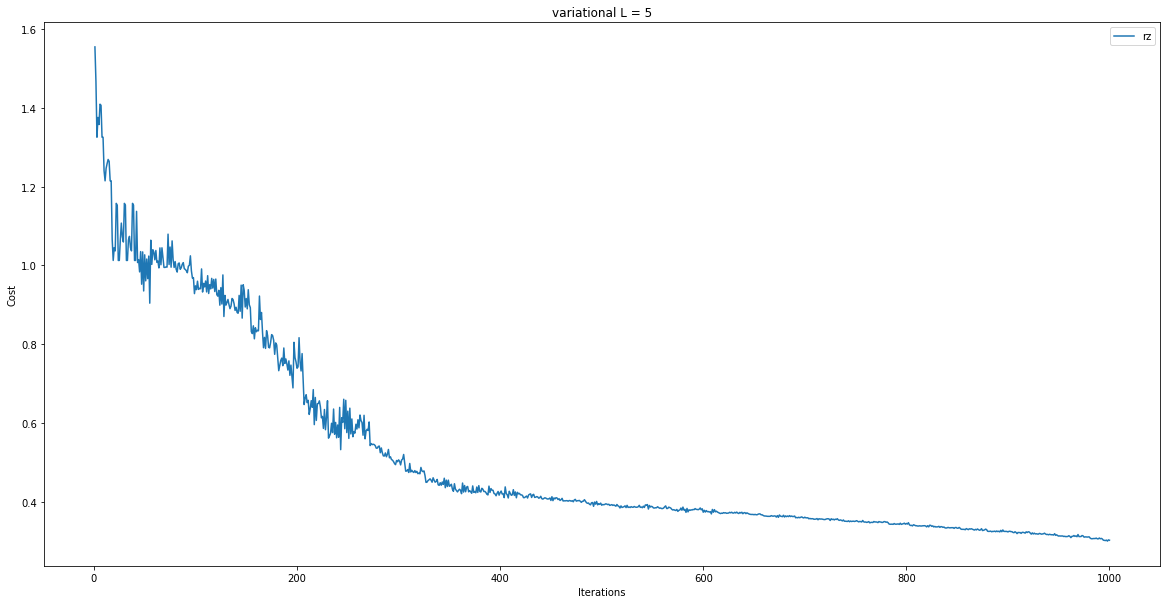

In [19]:
plt.figure(figsize=(20,10))
plt.plot(range(1, len(history) + 1), history)
plt.legend(['rz'], loc='upper right')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('variational L = {}'.format(L))
plt.show()

In [20]:
class variational:
    def __init__(self,L):
        self.QRegister = QuantumRegister(4)
        self.L = L
        self.params = np.zeros(shape=(L*8,))
        self.random_state_vector = np.array(random_statevector(dims=(16,)).data)
        self.simulator = Aer.get_backend('statevector_simulator')
        self.history = []
        bounds = [ [0,2*np.pi] for _ in range(self.L *8)]
        self.cons = []
        self.Nfeval = 1
        for factor in range(len(bounds)):
            lower, upper = bounds[factor]
            l = lambda x, lb=lower, i=factor: x[i] - lb
            u = lambda x, ub=upper, i=factor: ub - x[i]
            self.cons.append(l)
            self.cons.append(u)
    def Even(self,params=[0,0,0,0]):
        qc = QuantumCircuit(self.QRegister)
        qc.rz(params[0],0)
        qc.rz(params[1],1)
        qc.rz(params[2],2)
        qc.rz(params[3],3)
        qc.cz(0,1)
        qc.cz(0,2)
        qc.cz(0,3)
        qc.cz(1,2)
        qc.cz(1,3)
        qc.cz(2,3)
        return qc
    def Odd(self,params=[0,0,0,0]):
        qc = QuantumCircuit(self.QRegister)
        qc.rx(params[0],0)
        qc.rx(params[1],1)
        qc.rx(params[2],2)
        qc.rx(params[3],3)
        return qc
    def LayerBlock(self,params):
        qc = QuantumCircuit(self.QRegister)
        qc+=self.Odd(params[0:4])
        qc.barrier()
        qc+=self.Even(params[4:8])
        qc.barrier()
        return qc
    def Task1(self,params):
        qc = QuantumCircuit(self.QRegister)
        for i in range(self.L):
            qc += self.LayerBlock(params[8*i:8*(i+1)])
        return qc
    def loss_fn(self,a,b):
        return np.linalg.norm(a-b)
    def f(self,x):
        circ = self.Task1(params=x)
        job = execute(circ, self.simulator)
        result = job.result()
        state_vector = result.get_statevector(circ)
        circ.draw()
        loss = self.loss_fn(state_vector,self.random_state_vector)
        self.history.append(loss)
        if self.Nfeval % 100 == 0:
            print('{0:4d}   {1: 3.6f} '.format(self.Nfeval, loss))
        self.Nfeval  += 1
        return loss
    def train(self,show=False,maxiter=1000):
        self.Nfeval = 1
        print('{0:4s}   {1:9s}'.format('Iter', 'f(X)'))
        self.params = np.zeros(shape=(self.L*8,))
        res = fmin_cobyla(self.f,self.params,cons=self.cons,maxfun=maxiter)
        return res,self.history
    def plot(self):
        plt.figure(figsize=(20,10))
        plt.plot(range(1, len(self.history) + 1), self.history, 'b')
        plt.legend(['rz'], loc='upper right')
        plt.xlabel('Iterations')
        plt.ylabel('Cost')
        plt.title('variational {}'.format(self.L))
        # plt.show()



In [21]:
experiment = variational(5)
res,history = experiment.train(maxiter=200)

Iter   f(X)     
 100    0.885140 
 200    0.728200 


In [22]:
L_list = [1,3,5,10]
resList = []
historyList = []
for i in L_list:
    experiment = variational(i)
    res,history = experiment.train(maxiter=1000)
    historyList.append(history)

Iter   f(X)     
 100    0.973190 
Iter   f(X)     
 100    0.779019 
 200    0.707017 
 300    0.623760 
 400    0.605086 
 500    0.602345 
 600    0.601865 
 700    0.601815 
 800    0.601795 
 900    0.601718 
1000    0.601812 
Iter   f(X)     
 100    1.074720 
 200    0.971944 
 300    0.843626 
 400    0.800945 
 500    0.749936 
 600    0.730481 
 700    0.717753 
 800    0.713997 
 900    0.711505 
1000    0.709637 
Iter   f(X)     
 100    1.060861 
 200    1.055131 
 300    0.930303 
 400    0.873982 
 500    0.664897 
 600    0.604481 
 700    0.507499 
 800    0.465942 
 900    0.424172 
1000    0.424899 


Text(0.5, 1.0, 'L = 10')

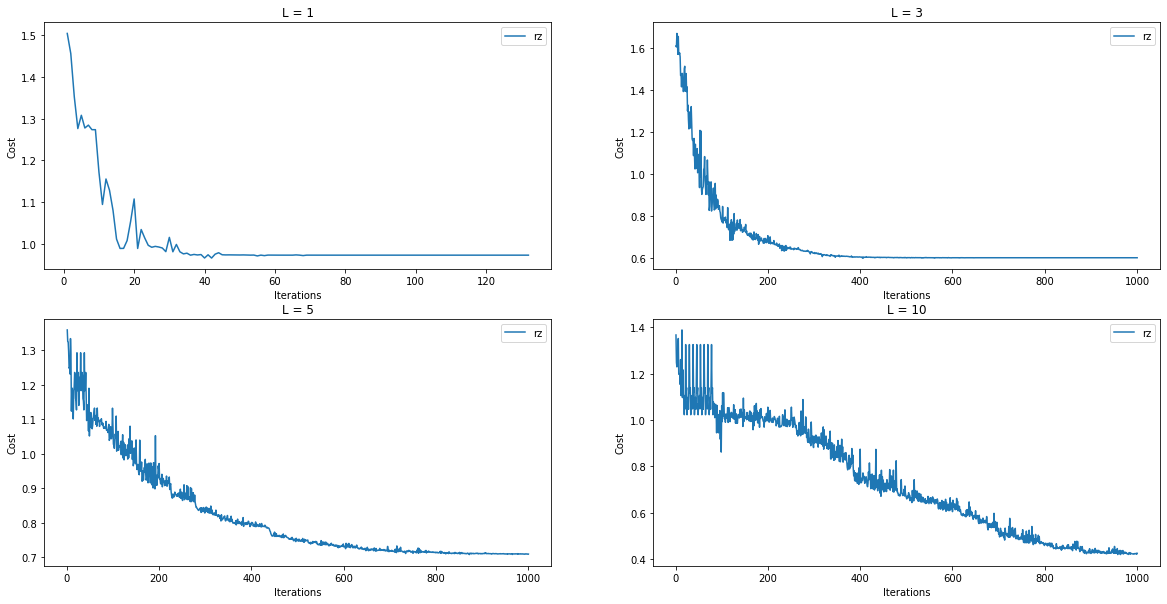

In [23]:
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.plot(range(1, len(historyList[0]) + 1), historyList[0])
plt.legend(['rz'], loc='upper right')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('L = 1')
plt.subplot(222)
plt.plot(range(1, len(historyList[1]) + 1), historyList[1])
plt.legend(['rz'], loc='upper right')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('L = 3')
plt.subplot(223)
plt.plot(range(1, len(historyList[2]) + 1), historyList[2])
plt.legend(['rz'], loc='upper right')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('L = 5')
plt.subplot(224)
plt.plot(range(1, len(historyList[3]) + 1), historyList[3])
plt.legend(['rz'], loc='upper right')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('L = 10')

# Bonus

In [25]:
'''
    Change Rx to Ry gate
'''
class variationalRy:
    def __init__(self,L):
        self.QRegister = QuantumRegister(4)
        self.L = L
        self.params = np.zeros(shape=(L*8,))
        self.random_state_vector = np.array(random_statevector(dims=(16,)).data)
        self.simulator = Aer.get_backend('statevector_simulator')
        self.history = []
        bounds = [ [0,2*np.pi] for _ in range(self.L *8)]
        self.cons = []
        self.Nfeval = 1
        for factor in range(len(bounds)):
            lower, upper = bounds[factor]
            l = lambda x, lb=lower, i=factor: x[i] - lb
            u = lambda x, ub=upper, i=factor: ub - x[i]
            self.cons.append(l)
            self.cons.append(u)
    def Even(self,params=[0,0,0,0]):
        qc = QuantumCircuit(self.QRegister)
        qc.rz(params[0],0)
        qc.rz(params[1],1)
        qc.rz(params[2],2)
        qc.rz(params[3],3)
        qc.cz(0,1)
        qc.cz(0,2)
        qc.cz(0,3)
        qc.cz(1,2)
        qc.cz(1,3)
        qc.cz(2,3)
        return qc
    def Odd(self,params=[0,0,0,0]):
        qc = QuantumCircuit(self.QRegister)
        qc.ry(params[0],0)
        qc.ry(params[1],1)
        qc.ry(params[2],2)
        qc.ry(params[3],3)
        return qc
    def LayerBlock(self,params):
        qc = QuantumCircuit(self.QRegister)
        qc+=self.Odd(params[0:4])
        qc.barrier()
        qc+=self.Even(params[4:8])
        qc.barrier()
        return qc
    def Task1(self,params):
        qc = QuantumCircuit(self.QRegister)
        for i in range(self.L):
            qc += self.LayerBlock(params[8*i:8*(i+1)])
        return qc
    def loss_fn(self,a,b):
        return np.linalg.norm(a-b)
    def f(self,x):
        circ = self.Task1(params=x)
        job = execute(circ, self.simulator)
        result = job.result()
        state_vector = result.get_statevector(circ)
        circ.draw()
        loss = self.loss_fn(state_vector,self.random_state_vector)
        self.history.append(loss)
        if self.Nfeval % 100 == 0:
            print('{0:4d}   {1: 3.6f} '.format(self.Nfeval, loss))
        self.Nfeval  += 1
        return loss
    def train(self,show=False,maxiter=1000):
        self.Nfeval = 1
        print('{0:4s}   {1:9s}'.format('Iter', 'f(X)'))
        self.params = np.zeros(shape=(self.L*8,))
        res = fmin_cobyla(self.f,self.params,cons=self.cons,maxfun=maxiter)
        return res,self.history
    def plot(self):
        plt.figure(figsize=(20,10))
        plt.plot(range(1, len(self.history) + 1), self.history, 'b')
        plt.legend(['rz'], loc='upper right')
        plt.xlabel('Iterations')
        plt.ylabel('Cost')
        plt.title('variational {}'.format(self.L))
        # plt.show()



In [26]:
experiment = variationalRy(5)
res,history = experiment.train(maxiter=3000)

Iter   f(X)     
 100    0.960492 
 200    0.867560 
 300    0.828659 
 400    0.766946 
 500    0.677387 
 600    0.580559 
 700    0.481194 
 800    0.435662 
 900    0.411100 
1000    0.364079 
1100    0.350478 
1200    0.339580 
1300    0.331748 
1400    0.321120 
1500    0.314589 
1600    0.309296 
1700    0.305527 
1800    0.301373 
1900    0.297518 
2000    0.293843 
2100    0.289652 
2200    0.285486 
2300    0.284788 
2400    0.282864 
2500    0.281577 
2600    0.280651 
2700    0.279777 
2800    0.279203 
2900    0.278607 
3000    0.278159 


In [27]:
experiment.random_state_vector.reshape(2,8)

array([[ 0.25382891+0.0046086j ,  0.02277197-0.37348575j,
        -0.17851465-0.17660172j,  0.0419967 -0.04890422j,
         0.12499008+0.04442504j,  0.23708518+0.19687757j,
        -0.07581301-0.18270797j, -0.32753672-0.07587878j],
       [-0.23211977+0.35061867j,  0.02459247-0.2019703j ,
         0.0882014 -0.05122339j,  0.04062715+0.04226303j,
         0.35241353+0.01129829j, -0.16906398-0.18147881j,
         0.05104006+0.11381028j, -0.02225064-0.17219622j]])

In [28]:
experiment.Task1(res).draw()

┌──────────────┐  ░ ┌─────────────┐                   ░ »
q6_0: ─┤ RY(0.048244) ├──░─┤ RZ(0.46574) ├─■──■──■───────────░─»
      ┌┴──────────────┴┐ ░ ├─────────────┤ │  │  │           ░ »
q6_1: ┤ RY(9.5368e-07) ├─░─┤ RZ(0.18186) ├─■──┼──┼──■──■─────░─»
      └┬─────────────┬─┘ ░ ├─────────────┤    │  │  │  │     ░ »
q6_2: ─┤ RY(0.22382) ├───░─┤ RZ(0.13551) ├────■──┼──■──┼──■──░─»
       └┬───────────┬┘   ░ ├─────────────┤       │     │  │  ░ »
q6_3: ──┤ RY(1.441) ├────░─┤ RZ(0.24784) ├───────■─────■──■──░─»
        └───────────┘    ░ └─────────────┘                   ░ »
«         ┌────────────┐   ░ ┌─────────────┐                   ░ »
«q6_0: ───┤ RY(1.7647) ├───░─┤ RZ(0.63215) ├─■──■──■───────────░─»
«      ┌──┴────────────┴─┐ ░ ├─────────────┤ │  │  │           ░ »
«q6_1: ┤ RY(-7.9443e-08) ├─░─┤ RZ(0.97994) ├─■──┼──┼──■──■─────░─»
«      └──┬────────────┬─┘ ░ ├─────────────┤    │  │  │  │     ░ »
«q6_2: ───┤ RY(1.0478) ├───░─┤ RZ(0.63838) ├────■──┼──■──┼──■──░─»
«         ├────────────┤   ░ └┬────────────┤       │     │  │  ░ »
«q6_3: ───┤ RY(2.7233) ├───░──┤ RZ(1.5879) ├───────■─────■──■──░─»
«         └────────────┘   ░  └────────────┘                   ░ »
«        ┌────────────┐   ░ ┌─────────────────┐                   ░ »
«q6_0: ──┤ RY(1.4504) ├───░─┤ RZ(-4.7974e-07) ├─■──■──■───────────░─»
«        ├────────────┤   ░ └─┬─────────────┬─┘ │  │  │           ░ »
«q6_1: ──┤ RY(1.2612) ├───░───┤ RZ(0.11406) ├───■──┼──┼──■──■─────░─»
«        ├────────────┤   ░  ┌┴─────────────┴┐     │  │  │  │     ░ »
«q6_2: ──┤ RY(1.2813) ├───░──┤ RZ(1.558e-07) ├─────■──┼──■──┼──■──░─»
«      ┌─┴────────────┴─┐ ░  ├───────────────┴┐       │     │  │  ░ »
«q6_3: ┤ RY(3.4037e-07) ├─░──┤ RZ(1.8565e-06) ├───────■─────■──■──░─»
«      └────────────────┘ ░  └────────────────┘                   ░ »
«        ┌─────────────┐   ░   ┌─────────────┐                     ░ »
«q6_0: ──┤ RY(0.36678) ├───░───┤ RZ(0.58018) ├───■──■──■───────────░─»
«        └┬────────────┤   ░   ├─────────────┤   │  │  │           ░ »
«q6_1: ───┤ RY(1.2428) ├───░───┤ RZ(0.67162) ├───■──┼──┼──■──■─────░─»
«      ┌──┴────────────┴─┐ ░ ┌─┴─────────────┴─┐    │  │  │  │     ░ »
«q6_2: ┤ RY(-3.5093e-08) ├─░─┤ RZ(-7.3431e-07) ├────■──┼──■──┼──■──░─»
«      └──┬────────────┬─┘ ░ └─┬─────────────┬─┘       │     │  │  ░ »
«q6_3: ───┤ RY(0.5304) ├───░───┤ RZ(0.30507) ├─────────■─────■──■──░─»
«         └────────────┘   ░   └─────────────┘                     ░ »
«         ┌────────────┐   ░ ┌─────────────────┐                   ░ 
«q6_0: ───┤ RY(1.1544) ├───░─┤ RZ(-8.2364e-07) ├─■──■──■───────────░─
«      ┌──┴────────────┴─┐ ░ └─┬─────────────┬─┘ │  │  │           ░ 
«q6_1: ┤ RY(-3.2662e-07) ├─░───┤ RZ(0.95191) ├───■──┼──┼──■──■─────░─
«      ├─────────────────┤ ░  ┌┴─────────────┴─┐    │  │  │  │     ░ 
«q6_2: ┤ RY(-9.3006e-07) ├─░──┤ RZ(2.4421e-07) ├────■──┼──■──┼──■──░─
«      └─┬─────────────┬─┘ ░ ┌┴────────────────┤       │     │  │  ░ 
«q6_3: ──┤ RY(0.88808) ├───░─┤ RZ(-9.4598e-08) ├───────■─────■──■──░─
«        └─────────────┘   ░ └─────────────────┘                   ░

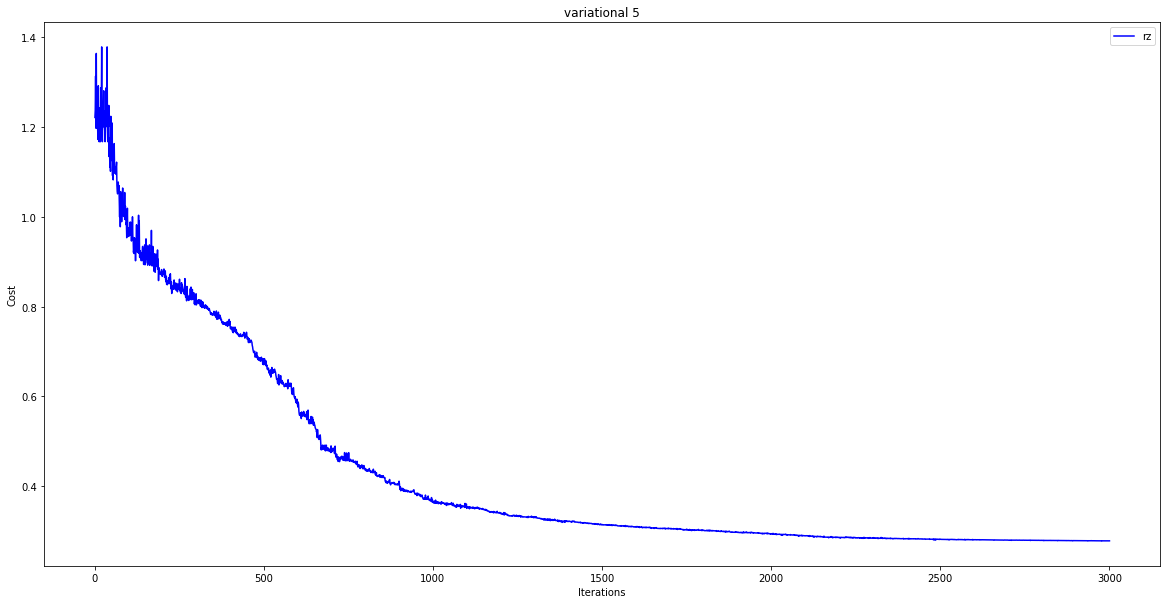

In [29]:
experiment.plot()

In [30]:
L_list = [1,3,5,10]
resList = []
historyList = []
for i in L_list:
    experiment = variationalRy(i)
    res,history = experiment.train(maxiter=1000)
    historyList.append(history)

Iter   f(X)     
 100    1.253658 
Iter   f(X)     
 100    0.835321 
 200    0.675326 
 300    0.657998 
 400    0.639783 
 500    0.603141 
 600    0.555818 
 700    0.493708 
 800    0.458174 
 900    0.443338 
1000    0.435683 
Iter   f(X)     
 100    1.022696 
 200    0.876111 
 300    0.823643 
 400    0.790111 
 500    0.768281 
 600    0.706157 
 700    0.597137 
 800    0.500270 
 900    0.431021 
1000    0.376355 
Iter   f(X)     
 100    0.727776 
 200    0.749367 
 300    0.762247 
 400    0.580862 
 500    0.526809 
 600    0.509086 
 700    0.480078 
 800    0.461214 
 900    0.446691 
1000    0.444783 


Text(0.5, 1.0, 'L = 10')

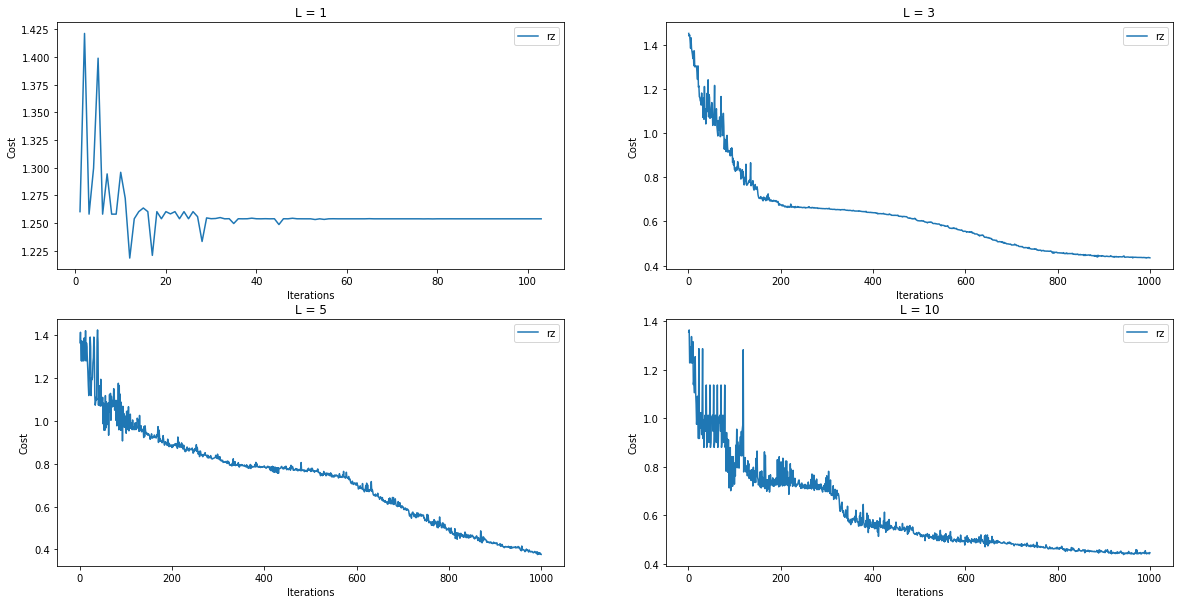

In [31]:
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.plot(range(1, len(historyList[0]) + 1), historyList[0])
plt.legend(['rz'], loc='upper right')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('L = 1')
plt.subplot(222)
plt.plot(range(1, len(historyList[1]) + 1), historyList[1])
plt.legend(['rz'], loc='upper right')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('L = 3')
plt.subplot(223)
plt.plot(range(1, len(historyList[2]) + 1), historyList[2])
plt.legend(['rz'], loc='upper right')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('L = 5')
plt.subplot(224)
plt.plot(range(1, len(historyList[3]) + 1), historyList[3])
plt.legend(['rz'], loc='upper right')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('L = 10')